# 📝 🌍 CSCI 1460 Machine Translation Assignment
In this project you will build a neural machine translation model using a Transformer encoder-decoder architecture. The primary goal of the assignment is to **implement the transformer yourself**! Outside of this class, you would likely use existing library implementations of Transformers, but for this assignment, we want you to get direct experience with the pieces that go into the full architecture.

The main learning objectives for this assignment are to:

1. Understand and implement a Transformer
2. Understand how a greedy decoding algorithm works and implement a beam search algorithm
3. Understand and implement the BLEU metric for evaluating machine translation
4. Understand the visualization of decoder attention during translation

***Make sure you're using a GPU runtime when you are training the model!*** Go to Runtime > Change runtime type to make sure you are on a GPU runtime when training these models.

# [DO NOT EDIT] Setup and Data Preprocessing

### You only need to **read through** and run this section. There are no coding TODOs for you. Feel free to collapse the cell with the arrow on the top left beside "Setup" (after reading through it)!

In [1]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 69.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [2]:
import random
import math
import copy
import io
import os

import torch
import torch.nn as nn
import numpy as np
from collections import Counter
from typing import Callable

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.utils import download_from_url, extract_archive
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from timeit import default_timer as timer

In [3]:
def seed_everything(s: int):
  """
  This function allows us to set the seed for all of our random functions
  so that we can get reproducible results.

  Parameters
  ----------
  s : int
      seed to seed all random functions with
  """
  random.seed(s)
  torch.manual_seed(s)
  torch.cuda.manual_seed_all(s)
  np.random.seed(s)
  torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)

In [4]:
# data loaded from multi30k dataset https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

# download and extract data
train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

# get tokenizers for English and German
de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [5]:
def build_vocab(filepath: str, tokenizer: Callable) -> torchtext.vocab.Vocab:
    """
    Builds a vocab based on a given file of sentence and a given tokenizer

    Parameters
    ----------
    filepath : str
        filepath from which to get sentences to generate a vocabulary
    tokenizer : Callable
        function with which to tokenize the sentences

    Returns
    ----------
    torchtext.vocab.Vocab
        a PyTorch vocab object
    """
    counter = Counter()
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f: # each string here is a German or English sentence
            counter.update(tokenizer(string_))
    return torchtext.vocab.vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

# build vocabularies for both languages based on the training data
de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

# sets the default behavior for OOV words to be <unk>
de_vocab.set_default_index(0)
en_vocab.set_default_index(0)

In [6]:
def data_process(filepaths: list[str]) -> list[tuple[torch.Tensor, torch.Tensor]]:
  """
  Builds a dataset of translated sentences from a list of filepaths

  Parameters
  ----------
  filepaths : list[str]
      a list containing the filepath to a German dataset and a filepath to
      the corresponding English dataset

  Returns
  ----------
  list[tuple[torch.Tensor, torch.Tensor]]
      a list of tuples of tensors, where each tuple is a pair of translations
      (German, English) in the form of tensors where tokenized words are encoded
      as vocabulary indices
  """
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    # raw_de and raw_en are paired sentences in English and German
    de_tensor_ = torch.tensor(de_vocab(de_tokenizer(raw_de)), dtype=torch.long)
    en_tensor_ = torch.tensor(en_vocab(en_tokenizer(raw_en)), dtype=torch.long)

    data.append((de_tensor_, en_tensor_))
  return data

# clean the data by tokenizing sentences and converting them to tensors
train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

In [7]:
# sets default values for the rest of the notebook
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # remember this for later!
BATCH_SIZE = 32
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

In [8]:
def generate_batch(data_batch: list[tuple[torch.Tensor, torch.Tensor]]) -> tuple[torch.Tensor, torch.Tensor]:
  """
  Used as the collate_fn argument when constructing DataLoaders to collate
  lists of samples into batches

  Parameters
  ----------
  data_batch : list[tuple[torch.Tensor, torch.Tensor]]
      a list of tuples of tensors, where each tuple is a pair of translations
      (German, English) in the form of tensors where tokenized words are encoded
      as vocabulary indices

  Returns
  ----------
  tuple[torch.Tensor, torch.Tensor]
      a tuple of batched German sentences and batched English sentences in the
      form of tensors of vocabulary indices
  """
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return de_batch, en_batch

# create data loaders for the training, validation, and test data
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=False, collate_fn=generate_batch)

# Part 1: Building a Transformer
In this section, we'll implement our own Transformer model using some PyTorch implementations of attention. Transformers were introduced in [2017 by Vaswani et al.](https://arxiv.org/abs/1706.03762) and consist of an encoder-decoder structure seen below.

First, in Part 1a, we'll implement the green encoder box, and then in Part 1b, we'll implement the pink decoder. We'll then link these modules together into a `ManualTransformer` class in Part 2c. Let's open up some boxes!

![image](https://drive.google.com/uc?id=1gsA8TgBRN020YwBSdtNUBX8xvnM-ZO93)

For more help in understanding transformers on a broader, conceptual level, check out Jay Alammar's [illustrated transformer](https://jalammar.github.io/illustrated-transformer/), which is where the rest of the illustrations in this assignment will be coming from. Reading the paper will also be helpful as it has more details (obviously) about the specific implementation details than the illustrated transformer article does.

### [DO NOT EDIT] Helper Code for ManualEncoder and ManualDecoder

This cell includes some modules and functions. **You should take a look at the code to see how it works, but you shouldn't need to edit any of it.**

Modules and Functions:
* `SublayerConnection`, a module that takes in a sublayer function (e.g. the forward pass of a feedforward layer or the forward pass of an attention module) and performs routine layer normalization and dropout on that sublayer
* `PositionwiseFeedForward`, a module that implements the feedforward network that is reused within the Transformer implementation
* `clones(module, N)` which takes in a module and returns a [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html?highlight=nn+modulelist#torch.nn.ModuleList) of N clones of that module.

In [9]:
class SublayerConnection(nn.Module):
    '''Applies a residual connection followed by a layer norm to any sublayer'''
    def __init__(self, size: int, dropout: float):
        """
        Initializes a SublayerConnection module

        Parameters
        ----------
        size : int
            size of the expected input to the module
        dropout : float
            dropout value to be used after the sublayer
        """
        super(SublayerConnection, self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, sublayer: nn.Module) -> torch.Tensor:
        """
        Forward pass of the model. Normalizes the input, applies the sublayer,
        performs a dropout, and then performs a residual connection.

        Parameters
        ----------
        x : torch.Tensor
            input Tensor
        sublayer : nn.Module
            layer that a residual connection is performed over

        Returns
        ----------
        torch.Tensor
            output of the forward pass
        """
        return x + self.dropout(sublayer(self.norm(x)))


class PositionwiseFeedForward(nn.Module):
    ''' Implements the two-layer feedforward neural network used in the transformer.'''
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        """
        Initializes a PositionwiseFeedForward module

        Parameters
        ----------
        d_model : int
            size of the input into and output out of the feedforward layer
        d_ff : int
            hidden size of the feedforward layer
        dropout : float
            dropout value used at end of feedforward layer
        """
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model. Normalizes the input, applies the sublayer,
        performs a dropout, and then performs a residual connection.

        Parameters
        ----------
        x : torch.Tensor
            input Tensor
        sublayer : nn.Module
            layer that a residual connection is performed over

        Returns
        ----------
        torch.Tensor
            output of the forward pass
        """
        return self.w_2(self.dropout(self.w_1(x).relu()))

def clones(module: nn.Module, N: int) -> nn.ModuleList:
    """
    Creates a nn.ModuleList of N identical copies of the inputted module

    Parameters
    ----------
    module : nn.Module
        module to clone
    N : int
        number of layers to clone

    Returns
    nn.ModuleList
        iterable list of the cloned layers
    ----------

    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## Part 1a: Building an Encoder Block

One green Transformer encoder box consists of *N* identical blocks stacked on top of each other.
![image](https://drive.google.com/uc?id=1VTYJOtyVx1L5UORqH29mNSIX1Gz0fgd0)


To implement one of these green layers, we will create a `ManualEncoderLayer` class, and then duplicate and stack these all together in our `ManualEncoder` class to create the stack of them.

### Implementing an Encoder Layer: `ManualEncoderLayer`
Each encoder layer consists of:
1. A self-attention sublayer (hint: `torch.nn.MultiheadAttention`)
2. A feed-forward sublayer (hint: the class we just gave you, `PositionwiseFeedForward`)

![image](https://drive.google.com/uc?id=1_miH3R_hRjDT-_CRFoSr_VhcbDm2o04o)


Make sure to create a new `SublayerConnection` module for each sublayer which will cleanly implement residual connections (the dotted lines and 'add' in the diagram) and a LayerNorm module ('normalize' in the diagram). For each sublayer, you will then pass a function that calls either your attention module or your feed-forward module into the `SublayerConnection` forward pass.


In [10]:
class ManualEncoderLayer(nn.Module):
    def __init__(self, size: int, dropout: float, nhead: int, dim_ff: int):
        """
        Initializes a ManualEncoderLayer module

        Parameters
        ----------
        size : int
            size of the input into and output out of the feedforward layer
        dropout : float
            dropout value used for attention, residual connection, and
            feedforward layers
        nhead : int
            number of attention heads used in multi-head attention
        dim_ff : int
            hidden dimension of the feedforward layer
        """
        super(ManualEncoderLayer, self).__init__()
        #TODO: Initialize the necessary pieces of the encoder block
        self.size = size
        self.attention = nn.MultiheadAttention(size, nhead, dropout=dropout)
        self.residual_norm1 = SublayerConnection(size=size, dropout=dropout)
        self.ff_layer = PositionwiseFeedForward(d_model=size, d_ff=dim_ff, dropout=dropout)
        self.residual_norm2 = SublayerConnection(size=size, dropout=dropout)

    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor):
        """
        Forward encoding pass for one layer.

        Parameters
        ----------
        x : torch.Tensor
            input Tensor
        padding_mask : torch.Tensor
            boolean mask Tensor displaying locations of padding tokens in
            the input

        Returns
        ----------
        torch.Tensor
            output of the forward pass
        """
        #TODO: Implement the forward pass
        attn_func = lambda x: self.attention(x, x, x, key_padding_mask=padding_mask)[0]
        out = self.residual_norm1(x, attn_func)
        out = self.residual_norm2(out, self.ff_layer)
        return out


### Implementing the Encoder: `ManualEncoder`
In the encoder itself, you want to
1. create *N* instances of the given ManualEncoderLayer (hint: check out the `clones` function we gave you above) and name them `layers`
2. stack together your *N* layers in the forward pass
3. perform layer normalization (`nn.LayerNorm`) one more time at the end. You might have to edit your `ManualEncoderLayer` so you can get the required input size.

In [11]:
class ManualEncoder(nn.Module):
    def __init__(self, layer: nn.Module, N: int):
        """
        Initializes a ManualEncoder module

        Parameters
        ----------
        layer : nn.Module
            a ManualEncoderLayer
        N : int
            number of encoder layers in the encoder
        """
        super(ManualEncoder, self).__init__()
        #TODO: Initialize the necessary pieces of the encoder
        # (Hint, this mostly consists of making copies of your encoder layers)
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(self.layers[-1].size)

    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor):
        """
        Full encoder forward pass.

        Parameters
        ----------
        x : torch.Tensor
            input Tensor
        padding_mask : torch.Tensor
            boolean mask Tensor displaying locations of padding tokens in
            the input

        Returns
        ----------
        torch.Tensor
            output of the forward pass
        """
        #TODO: Implement the forward pass
        out = x
        for layer in self.layers:
          out = layer(out, padding_mask)
        return self.norm(out)

## Part 1b: Building a Decoder Block
The decoder works the same way, with six identical `ManualDecoderLayer`s stacked on top of each other in our `ManualDecoder` class.

### Implementing a Decoder Layer: `ManualDecoderLayer`

A single decoder layer consists of:
1. A self-attention sublayer
2. A cross-attention sublayer (encoder-decoder attention)
3. A feed-forward sublayer

![image](https://drive.google.com/uc?id=1oU4jlveCwWme58UUwwXs4MEGTnFOtpUA)

Again, you will want to use a bunch of `SublayerConnection` modules to handle the residual connections and layer normalizations.

**Important:** for the analysis code we give you in Part 3, you will have to save the attention weights of the cross-attention sublayer in the variable `self.attn_weights`. Because of the sublayer setup, this will be a little weird. Do your forward pass normally, but then also separately call your cross-attention module with `need_weights=True` to get out and save the attention weights for that section. (look [here](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) for what `need_weights` actually does).

In [12]:
class ManualDecoderLayer(nn.Module):
    def __init__(self, size: int, dropout: float, nhead: int, dim_ff: int):
        """
        Initializes a ManualDecoderLayer module

        Parameters
        ----------
        size : int
            size of the input into and output out of the feedforward layer
        dropout : float
            dropout value used for attention, residual connection, and
            feedforward layers
        nhead : int
            number of attention heads used in multi-head attention
        dim_ff : int
            hidden dimension of the feedforward layer
        """
        super(ManualDecoderLayer, self).__init__()
        #TODO: Initialize the necessary pieces of the decoder block
        self.size = size
        self.attn_weights = None

        self.attention_1 = nn.MultiheadAttention(size, nhead, dropout=dropout)
        self.residual_norm1 = SublayerConnection(size=size, dropout=dropout)

        self.attention_2 = nn.MultiheadAttention(size, nhead, dropout=dropout)
        self.residual_norm2 = SublayerConnection(size=size, dropout=dropout)

        self.ff_layer = PositionwiseFeedForward(d_model=size, d_ff=dim_ff, dropout=dropout)
        self.residual_norm3 = SublayerConnection(size=size, dropout=dropout)

    def forward(self, x: torch.Tensor, src_encoding: torch.Tensor,
                src_padding_mask: torch.Tensor, tgt_mask: torch.Tensor, tgt_padding_mask: torch.Tensor):
        """
        Forward decoding pass for one layer.

        Parameters
        ----------
        x : torch.Tensor
            input Tensor (model's target sequence)
        src_encoding : torch.Tensor
            output of the encoder
        src_padding_mask : torch.Tensor
            boolean mask Tensor displaying locations of padding tokens in
            the "encoded input" (src_encoding)
        tgt_mask : torch.Tensor
            boolean mask Tensor displaying locations of tokens in target to
            mask attention to
        tgt_padding_mask : torch.Tensor
            boolean mask Tensor displaying locations of padding tokens in
            the input (target sequence)

        Returns
        ----------
        torch.Tensor
            output of the forward pass
        """
        #TODO: Implement the forward pass
        attn_func = lambda x: self.attention_1(x, x, x, attn_mask=tgt_mask, key_padding_mask=tgt_padding_mask)[0]
        out = self.residual_norm1(x, attn_func)

        attn_func = lambda x: self.attention_2(x, src_encoding, src_encoding, key_padding_mask=src_padding_mask)[0]
        _, self.attn_weights = self.attention_2(x, src_encoding, src_encoding, key_padding_mask=src_padding_mask, need_weights=True)
        out = self.residual_norm2(out, attn_func)

        out = self.residual_norm3(out, self.ff_layer)
        return out

### Implementing the Decoder: `ManualDecoder`
Now, we can combine as many decoder layers as we want in our decoder class, which should look very similar to our `ManualEncoder` class.

1. create *N* instances of the given `ManualDecoderLayer` (hint: check out the `clones` function we gave you above) and name them `layers`
2. stack together your *N* layers in the forward pass
3. perform layer normalization (`nn.LayerNorm`) one more time at the end. You might have to edit your `ManualDecoderLayer` so you can get the required input size.

In [13]:
class ManualDecoder(nn.Module):
    def __init__(self, layer: nn.Module, N: int):
        """
        Initializes a ManualDecoder module

        Parameters
        ----------
        layer : nn.Module
            a ManualDecoderLayer
        N : int
            number of decoder layers in the decoder
        """
        super(ManualDecoder, self).__init__()
        #TODO: Initialize the necessary pieces of the decoder
        # (Hint, the mostly consists of making copies of your decoder layers)
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(self.layers[-1].size)

    def forward(self, x: torch.Tensor, src_encoding: torch.Tensor, src_padding_mask: torch.Tensor,
                tgt_mask: torch.Tensor, tgt_padding_mask: torch.Tensor):
        """
        Full decoder forward pass.

        Parameters
        ----------
        x : torch.Tensor
            input Tensor (model's target sequence)
        src_encoding : torch.Tensor
            output of the encoder
        src_padding_mask : torch.Tensor
            boolean mask Tensor displaying locations of padding tokens in
            the "encoded input" (src_encoding)
        tgt_mask : torch.Tensor
            boolean mask Tensor displaying locations of tokens in target to
            mask attention to
        tgt_padding_mask : torch.Tensor
            boolean mask Tensor displaying locations of padding tokens in
            the input (target sequence)

        Returns
        ----------
        torch.Tensor
            output of the forward pass
        """
        #TODO: Implement the forward pass
        out = x
        for layer in self.layers:
          out = layer(out, src_encoding, src_padding_mask, tgt_mask, tgt_padding_mask)
        return self.norm(out)

## Part 1c: Putting Everything Together

Finally, we can implement the last few details. We've already taken care of mostly everything on here - recognize the multi-head attention, layer normalization, and feed-forward networks?

![image](https://drive.google.com/uc?id=1Rr9ezcbbW8UAaTSfY-7snHeKrVJHAyoz)

There's just a few more things to take care of. In the `ManualTransformer` class, you should put together your encoder and decoder and add token embeddings, positional encodings, and a final linear layer `out` to project from the embeddings to the target vocabulary. You can use these pieces to implement `encode` and `decode`, then call these two in `forward`. We have already defined the `TokenEmbedding` and `PositionalEncoding` classes for you, which you should look over to see how they work. **DO NOT EDIT THEM.** Here's some more info about them:

* `TokenEmbedding`, basically a PyTorch [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module except it also multiplies the embeddings by $\sqrt{d_{model}}$ as specified in Vaswani et al. 2017
* `PositionalEncoding`, a PyTorch module whose forward pass adds positional encodings to the inputted embeddings

You'll have to implement `get_tgt_mask` as well. This will get used in `decode` to apply masks to the inputted target data. When masking, we use a value of **0/False to keep the token** and **1/True to mask out the token**. We would like you to have boolean masks, you can either use the `.bool()` function or the kwarg `dtype=torch.bool` to convert int/float tensors to booleans. Also make sure that it is on `device`! (The variable `device` is defined in the setup code that you read through.) If you're having trouble figuring out the output shape, take a look at the expected sizes of arguments to `torch.nn.MultiheadAttention`.

In [14]:
## DO NOT EDIT THIS CELL
class TokenEmbedding(nn.Module):
    ''' Embedding layer with weights defined by a vocabulary and an embedding size'''
    def __init__(self, vocab_size: int, emb_size: int):
        """
        Initializes a TokenEmbedding module

        Parameters
        ----------
        vocab_size : int
            size of the vocab that embeddings will be from
        emb_size : int
            embedding size
        """
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        """
        Returns the embedding of the tokens multiplied by sqrt(emb_size)

        Parameters
        ----------
        tokens : torch.Tensor
            input Tensor in the form of batched tokenized sentences using
            vocabulary indices

        Returns
        ----------
        torch.Tensor
            output of the embeddings
        """
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class PositionalEncoding(nn.Module):
    ''' Positional encoding layer for the transformer. '''
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        """
        Initializes a PositionalEncoding module. The math here isn't important
        to have a firm grasp of, but the transformer explanation
        linked above does explain how this works visually. :)

        Parameters
        ----------
        emb_size : int
            embedding size from TokenEmbedding
        dropout : float
            dropout to be used after encoding all the inputs
        maxlen : int
            maximum length of the sentence
        """
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: torch.Tensor):
        """
        Returns the sum of the token embedding and the positional embedding.
        Again, see the transformer visualization for more information.

        Parameters
        ----------
        token_embedding : torch.Tensor
            input Tensor from a TokenEmbedding layer

        Returns
        ----------
        torch.Tensor
            a positionally-encoded sentence representation
        """
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [15]:
class ManualTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int, emb_size: int, nhead: int,
                 src_vocab_size: int, tgt_vocab_size: int, dim_ff: int = 512, dropout: float = 0.1):
        """
        Initializes a ManualTransformer module.

        Parameters
        ----------
        num_encoder_layers : int
            number of encoder layers in the transformer
        num_decoder_layers : int
            number of decoder layers in the transformer
        emb_size : int
            embedding size used for token embedding, positional encoding,
            and encoding and decoding
        nhead : int
            number of heads to use for multi-head attention in the encoder and
            decoder
        src_vocab_size : int
            vocab size of the input sentences of the transformer
        tgt_vocab_size : int
            vocab size of the target sentences of the transformer
        dim_ff : int
            hidden dimension of the feedforward layers
        dropout : float
            dropout to be used after encoding all the inputs
        """
        super(ManualTransformer, self).__init__()

        # TODO: Initialize the necessary pieces of the transformer
        self.encode_embed = TokenEmbedding(vocab_size=src_vocab_size, emb_size=emb_size)
        self.decode_embed = TokenEmbedding(vocab_size=tgt_vocab_size, emb_size=emb_size)
        self.encode_pos = PositionalEncoding(emb_size=emb_size, dropout=dropout)
        self.decode_pos = PositionalEncoding(emb_size=emb_size, dropout=dropout)

        encoder_layer = ManualEncoderLayer(size=emb_size, dropout=dropout, nhead=nhead, dim_ff=dim_ff)
        self.encoder = ManualEncoder(layer=encoder_layer, N=num_encoder_layers)

        decoder_layer = ManualDecoderLayer(size=emb_size, dropout=dropout, nhead=nhead, dim_ff=dim_ff)
        self.decoder = ManualDecoder(layer=decoder_layer, N=num_decoder_layers)

        self.linear = nn.Linear(emb_size, tgt_vocab_size)
        # self.softmax = nn.Softmax(dim=-1)

        ### DO NOT EDIT ###
        # Initialize parameters with Glorot / fan_avg.
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def get_tgt_mask(self, tgt: torch.Tensor) -> torch.Tensor:
        """
        Returns a mask of the target sequence to be used with attention
        during decoding

        Parameters
        ----------
        tgt : torch.Tensor
            model's target sequence

        Returns
        ----------
        torch.Tensor
            boolean mask Tensor displaying locations of tokens in target to
            mask attention to
        """
        #TODO: Implement next word mask for the target, which masks out all subsequent words
          # *hint* - torch.triu

        tgt_len = tgt.size(0)
        tgt_mask = torch.triu(torch.ones(tgt_len, tgt_len, device=device), diagonal=1)
        tgt_mask = tgt_mask.bool()
        return tgt_mask

    def encode(self, src: torch.Tensor, src_padding_mask: torch.Tensor) -> torch.Tensor:
        """
        Full encoding pass.

        Parameters
        ----------
        src : torch.Tensor
            model's input sequence (in form of input vocab indices)
        src_padding_mask : torch.Tensor
            boolean mask Tensor displaying locations of padding tokens in
            the input sequence

        Returns
        ----------
        torch.Tensor
            output of the full encoder pass
        """
        #TODO Implement the encode function
        embed = self.encode_embed(src)
        encode = self.encode_pos(embed)
        return self.encoder(encode, src_padding_mask)

    def decode(self, tgt: torch.Tensor, src_encoding:torch.Tensor,
               src_padding_mask: torch.Tensor, tgt_padding_mask: torch.Tensor) -> torch.Tensor:
        """
        Full decoding pass.

        Parameters
        ----------
        tgt : torch.Tensor
            model's target sequence
        src_encoding : torch.Tensor
            output of the encoder
        src_padding_mask : torch.Tensor
            boolean mask Tensor displaying locations of padding tokens in
            the "encoded input" (src_encoding)
        tgt_padding_mask : torch.Tensor
            boolean mask Tensor displaying locations of padding tokens in
            the input (target sequence)

        Returns
        ----------
        torch.Tensor
            output of the forward pass
        """
        #TODO Implement the decode function
        embed = self.decode_embed(tgt)
        encode = self.decode_pos(embed)
        tgt_mask = self.get_tgt_mask(encode)
        return self.decoder(encode, src_encoding, src_padding_mask, tgt_mask, tgt_padding_mask)

    def forward(self, src: torch.Tensor, tgt: torch.Tensor,
                src_padding_mask: torch.Tensor, tgt_padding_mask: torch.Tensor) -> torch.Tensor:
        """
        Full forward pass of the transformer.

        Parameters
        ----------
        src : torch.Tensor
            model's input sequence (in form of input vocab indices)
        tgt : torch.Tensor
            model's target sequence (in form of target vocab indices)
        src_padding_mask : torch.Tensor
            boolean mask Tensor displaying locations of padding tokens in
            the input sequence
        tgt_padding_mask : torch.Tensor
            boolean mask Tensor displaying locations of padding tokens in
            the target sequence

        Returns
        ----------
        torch.Tensor
            output of the forward pass
        """
        #TODO Implement the forward pass
        encoded = self.encode(src, src_padding_mask)
        decoded = self.decode(tgt, encoded, src_padding_mask, tgt_padding_mask)

        output = self.linear(decoded)
        return output
        # return self.softmax(output)


### Training the Model

Here, we'll write the code to actually train and evaluate our `ManualTransformer`. First, you can sanity check and verify that your model is training properly by training for an epoch and making sure that the results look like this (it's okay if the epoch time is different, just make sure the losses are *about* the same):

```
Epoch 1, Train loss: 3.999, Val loss: 3.041, Epoch time = 46.511s
```
Once you're sure the model works, you can train it for 15 epochs and proceed to the next section.

In [16]:
def padding_mask(idx_tensor: torch.Tensor) -> torch.Tensor:
    """
    Returns a boolean mask where True indicates that the token is a padding token.

    Parameters
    ----------
    idx_tensor : torch.Tensor
        tensor for which a padding mask should be generated

    Returns
    ----------
    torch.Tensor
        boolean mask of padding of input tensor
    """
    return (idx_tensor == PAD_IDX).transpose(0, 1)

In [17]:
def train_epoch(model:nn.Module, train_dataloader: DataLoader,
                loss_fn: nn.Module, optimizer:torch.optim.Optimizer) -> float:
    """
    Trains the inputted model using the provided data, optimizer, and loss
    function for one epoch. Returns the average loss of the epoch.

    Parameters
    ----------
    model : nn.Module
        model to train
    optimizer : torch.optim.Optimizer
        optimizer to use with training
    train_dataloader : DataLoader
        training data
    loss_fn : nn.Module
        loss function to use with training

    Returns
    ----------
    float
        epoch average loss
    """
    model.train()
    total_loss = 0

    for src, tgt in train_dataloader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:-1, :]

        src_padding_mask = padding_mask(src)
        tgt_padding_mask = padding_mask(tgt_input)

        logits = model(src, tgt_input, src_padding_mask, tgt_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_dataloader)

def val(model: nn.Module, val_dataloader: DataLoader, loss_fn: nn.Module) -> float:
    """
    Performs validation on the inputted model using the provided data and loss
    function for one epoch. Returns the validation loss.

    Parameters
    ----------
    model : nn.Module
        model to train
    val_dataloader : DataLoader
        validation data
    loss_fn : nn.Module
        loss function to use to calculate validation loss

    Returns
    ----------
    float
        average validation loss
    """
    model.eval()
    losses = 0
    for src, tgt in val_dataloader:
        src, tgt = src.to(device), tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_padding_mask = padding_mask(src)
        tgt_padding_mask = padding_mask(tgt_input)

        logits = model(src, tgt_input, src_padding_mask, tgt_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [18]:
def train(model: nn.Module, train_dataloader : DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, n_epochs:int=10):
    """
    Trains the inputted model using the provided data, optimizer, and loss
    function for n epochs. Prints the average loss of the training epoch
    and the validation loss after each epoch.

    Parameters
    ----------
    model : nn.Module
        model to train
    train_dataloader : DataLoader
        training data
    loss_fn : nn.Module
        loss function to use with training
    optimizer : torch.optim.Optimizer
        optimizer to use with training
    n_epochs : int
        number of epochs to train for
    """

    model = model.to(device)

    for epoch in range(1, n_epochs+1):
        print(f"Epoch {epoch},", end = " ")
        start_time = timer()
        train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer)
        end_time = timer()
        print(f" Train loss: {train_loss:.3f}, Epoch time = {(end_time - start_time):.3f}s", end = " ")

        val_loss = val(model, val_loader, loss_fn)
        print(f" Val loss: {val_loss:.3f}")

In [19]:
# initialize the Transformer Model
manual_transformer = ManualTransformer(num_encoder_layers=3, num_decoder_layers=3, emb_size=512, nhead=8, src_vocab_size=len(de_vocab), tgt_vocab_size=len(en_vocab))

# define our loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(manual_transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# train the model, change n_epochs to 15 when you're ready!
train(manual_transformer, train_loader, loss_fn, optimizer, n_epochs=15)

Epoch 1,  Train loss: 3.993, Epoch time = 25.691s  Val loss: 3.036
Epoch 2,  Train loss: 2.813, Epoch time = 25.192s  Val loss: 2.496
Epoch 3,  Train loss: 2.343, Epoch time = 25.176s  Val loss: 2.160
Epoch 4,  Train loss: 2.037, Epoch time = 25.218s  Val loss: 1.975
Epoch 5,  Train loss: 1.815, Epoch time = 25.220s  Val loss: 1.884
Epoch 6,  Train loss: 1.645, Epoch time = 25.207s  Val loss: 1.800
Epoch 7,  Train loss: 1.506, Epoch time = 25.240s  Val loss: 1.741
Epoch 8,  Train loss: 1.390, Epoch time = 25.222s  Val loss: 1.726
Epoch 9,  Train loss: 1.291, Epoch time = 25.245s  Val loss: 1.708
Epoch 10,  Train loss: 1.201, Epoch time = 25.250s  Val loss: 1.696
Epoch 11,  Train loss: 1.124, Epoch time = 25.251s  Val loss: 1.696
Epoch 12,  Train loss: 1.051, Epoch time = 25.223s  Val loss: 1.693
Epoch 13,  Train loss: 0.985, Epoch time = 25.234s  Val loss: 1.716
Epoch 14,  Train loss: 0.928, Epoch time = 25.254s  Val loss: 1.728
Epoch 15,  Train loss: 0.873, Epoch time = 25.255s  Val l

# Part 2: Evaluating our Transformer

BLEU is a metric between zero and one that measures the quality of a machine translation against a set of high-quality "ground truth" reference translations. It is almost impossible to get a perfect score of 1, even for human translators, but it has been shown that BLEU scores correlate with human evaluations of quality. It's difficult to compare BLEU metrics across corpora, but a score of about 30% is generally considered decent.


## Part 2a: Getting Translations Out of Our Model
Before we can actually calculate BLEU though, we need to get our outputs from the model.

### [DO NOT EDIT] Greedy decoding to get outputs
Here we've given you some code to get predictions from the trained model. Here's a description of the functions we've given you:
- `tokenlist_to_strlist(tokens, vocab)`, which takes in a list of tokens and outputs a list of the strings that correspond to each token
- `tokenlist_to_str(tokens, vocab, show_pad=False)`, which calls the function above and then turns the resulting list of strings into a single sentence. If `show_pad` is True, prints out the \<pad\> tokens.
- `translate_tokens(model, src_tokens)`, which takes in a Transformer model and tokens for a German source sentence and outputs a list of tokens that are an English translation of the sentence
- `translate(model, src_sentence)`, which takes in a Transformer model and a German source sentence as a string, and returns a string English translation.
- `greedy_decode(model, src, max_len, start_symbol)` This takes in a model, input source token tensor, int max_len and start_symbol index. This function repeated calls the model to produce generated output from the model until the model produces an EOS token or the `max_len` is reached. The first decoder input id is the `start_symbol`. Importantly, this is a **greedy** decode of the model so we take the highest probability token at each sequence step. This returns the sequence of tokens generated by the model.

**TODO**

- `beam_search(model, src, max_len, start_symbol, num_beams)` For this method you'll have to implement beam search! This can be a very tricky algorithm to implement so **we recommmend adapting the `greedy_decode` method** so that it now uses beam search instead of a greedy search algorithm. We also recommend using `torch.topk` to find the next tokens of the highest probablity and `heapq.nlargest` to find the current best beams to continue searching down. **If you get stuck, move on and come back to it** - you can just use the `greedy_decode` algorithm instead to look at how your model performs!

In [20]:
from torch.nn.functional import softmax
import heapq

def greedy_decode(model: nn.Module, src: torch.Tensor, max_len: int,
                  start_symbol: int) -> tuple[torch.Tensor, float]:
    """
    Function to generate a translation using a greedy decoding algorithm

    Parameters
    ----------
    model : nn.Module
        trained model to decode from
    src : torch.Tensor
        sequence inputted into model
    max_len : int
        maximum length to generate with decoding
    optimizer : torch.optim.Optimizer
        optimizer to use with training
    start_symbol : int
        vocabulary index to the start of sentence token

    Returns
    ----------
    tuple[torch.Tensor, float]
        a tuple of a tensor containing the sentence found using greedy
        decode represented using vocabulary indices, and the probability
        associated with that sentence
    """

    src = src.to(device)
    src_padding_mask = padding_mask(src)

    total_prob = 1.0

    src_encoding = model.encode(src, src_padding_mask).to(device)
    seq = torch.ones((1, 1), dtype=torch.long, device=device).fill_(start_symbol)
    for i in range(max_len-1):
        tgt_padding_mask = padding_mask(seq)
        out = model.decode(seq, src_encoding, src_padding_mask, tgt_padding_mask).to(device)
        out = out.transpose(0, 1).to(device)
        probs = softmax(model.linear(out[:, -1]), dim=-1)
        prob, next_word = torch.max(probs, dim=1)
        total_prob *= prob.item()
        next_word = next_word.item()

        seq = torch.cat([seq, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)

        if next_word == EOS_IDX:
            break
    return seq.flatten(), total_prob

def beam_search(model: nn.Module, src: torch.Tensor, max_len: int, start_symbol: int,
                beam_size: int) -> tuple[torch.Tensor, float]:
    """
    Function to generate a translation using a beam search algorithm

    Parameters
    ----------
    model : nn.Module
        trained model to decode from
    src : torch.Tensor
        sequence inputted into model
    max_len : int
        maximum length to generate with decoding
    optimizer : torch.optim.Optimizer
        optimizer to use with training
    start_symbol : int
        vocabulary index to the start of sentence token
    beam_size : int
        size of the beam using during the search

    Returns
    ----------
    tuple[torch.Tensor, float]
        a tuple of a tensor containing the sentence found using beam
        search represented using vocabulary indices, and the probability
        associated with that sentence
    """
    # TODO: Implement beam search
    src = src.to(device)
    src_padding_mask = padding_mask(src)

    src_encoding = model.encode(src, src_padding_mask).to(device)

    # list of (seq, prob)
    beams = [(torch.ones((1, 1), dtype=torch.long, device=device).fill_(start_symbol), 1.0)]

    for i in range(max_len-1):
        new_beams = []

        for seq, prob in beams:
            if seq[-1] == EOS_IDX:
                new_beams.append((seq, prob))
                continue

            tgt_padding_mask = padding_mask(seq)
            out = model.decode(seq, src_encoding, src_padding_mask, tgt_padding_mask).to(device)
            out = out.transpose(0, 1).to(device)
            probs = softmax(model.linear(out[:, -1]), dim=-1)
            topk_probs, topk_words = torch.topk(probs, k=beam_size)

            for j in range(beam_size):
                word_prob = topk_probs[0][j].item()
                word = topk_words[0][j].item()
                new_seq = torch.cat([seq, torch.ones(1, 1).type_as(src.data).fill_(word)], dim=0)
                new_prob = prob * word_prob

                new_beams.append((new_seq, new_prob))

        # Keep the top-k beams
        beams = heapq.nlargest(beam_size, new_beams, key=lambda x: x[1])

    # Find the beam with the highest probability
    best_beam = max(beams, key=lambda x: x[1])

    return best_beam[0].flatten(), best_beam[1]

In [21]:
def tokenlist_to_strlist(tokens: torch.Tensor, vocab: torchtext.vocab.Vocab) -> list[str]:
    """
    Converts a tensor representation of a list of tokens to a list of strings.

    Parameters
    ----------
    tokens : torch.Tensor
        tensor representation of a list of tokens
    vocab : torchtext.vocab.Vocab
        vocabulary associated with the given tokens

    Returns
    ----------
    list[str]
        returns a representation of the tokens in the form of a list of word strings
    """
    return vocab.lookup_tokens(list(tokens.cpu().numpy()))

def tokenlist_to_str(tokens: torch.Tensor, vocab: torchtext.vocab.Vocab,
                     show_pad: bool=False) -> str:
    """
    Converts a tensor representation of a list of tokens to a string, ignoring start
    and end of sentence tokens, and optionally ignoring padding tokens.

    Parameters
    ----------
    tokens : torch.Tensor
        tensor representation of a list of tokens
    vocab : torchtext.vocab.Vocab
        vocabulary associated with the given tokens
    show_pad : bool
        whether the outputted string should contain pad tokens or not

    Returns
    ----------
    str
        returns a representation of the tokens in the form of a string
    """
    out = " ".join(tokenlist_to_strlist(tokens, vocab)).replace("<bos>", "").replace("<eos>", "")
    if show_pad:
        return out
    else:
        return out.replace("<pad>", "")

def translate_tokens(model: nn.Module, src_tokens: torch.Tensor) -> tuple[torch.Tensor, float]:
    """
    Takes a tensor of source tokens and "translates" them by inputting them into
    the model and using either greedy decode or beam search to decode the output

    Parameters
    ----------
    model : nn.Module
        trained model to input tokens into
    src_tokens : torch.Tensor
        tensor representations of input sentences without start and end of
        sentence indices

    Returns
    ----------
    tuple[torch.Tensor, float]
        a tuple of a tensor containing the sentence found using either greedy
        decode or beam search represented using vocabulary indices, and the
        probability associated with that sentence
    """
    model.eval()
    src_tokens = torch.cat([torch.tensor([BOS_IDX]), src_tokens, torch.tensor([EOS_IDX])], dim=0).view(-1, 1)
    num_tokens = src_tokens.shape[0]

    # TODO: uncomment the below line and comment out the greedy_decode line to run beam_search!

    tgt_tokens, prob = beam_search(model, src_tokens, num_tokens + 5, BOS_IDX, 5)
    # tgt_tokens, prob = greedy_decode(model, src_tokens, num_tokens + 5, BOS_IDX)
    return tgt_tokens, prob

def translate(model: nn.Module, src_sentence: str,
              output_tokens: bool=False) -> tuple[str, torch.Tensor, torch.Tensor] | tuple[str, float]:
    """
    Takes a sentence string and "translates" it

    Parameters
    ----------
    model : nn.Module
        trained model to input tokens into
    src_sentence : str
        string representation of input sentence
    output_tokens : bool
        whether the source and target tokens are also outputted

    Returns
    ----------
    tuple[str, torch.Tensor, torch.Tensor]
        a string representation of the translated sentence, the tensor
        representation of the input, and the tensor representation of the
        translated sentence. Used in analyze_sentence below
    OR
    tuple[str, float]
        a string represention of the translated sentence and the
        probability associated with that sentence
    """
    model.eval()
    src_tokens = torch.tensor(de_vocab(de_tokenizer(src_sentence)), dtype=torch.long)
    tgt_tokens, prob = translate_tokens(model, src_tokens)
    translation = tokenlist_to_str(tgt_tokens, en_vocab)
    if output_tokens:
      return translation, src_tokens, tgt_tokens
    else:
      return translation, prob

### Take a look at the outputs!
In this cell, we encourage you to try some sentences in German to see how well the model does at translating them into English! You can even take some examples from `val_data` yourself to test on. `val_data` is a list of `(de_tokenlist, en_tokenlist)` tuples which you can convert to strings using one of the functions above.

Try looking up the paper for the Multi30k dataset online, and see where our language data came from. Does that provide an explanation for why some sentences have better translations than others?

You can also change around the number of epochs the model trains for and see how that impacts qualitative performance. Just make sure to change it back after before handing things in.


In [22]:
def pretty_print(translation: str, prob: float):
    """
    Prints a translation and its associated probability nicely

    Parameters
    ----------
    translation : str
        translation string
    prob : float
        probability associated with translation
    """
    print(translation, f"Probability: {prob}")
    print()

pretty_print(*translate(manual_transformer, "Ein Mann auf einem Maisfeld mit einem Hund"))
pretty_print(*translate(manual_transformer, "Drei Kinder essen Eis, während ein Elternteil zuschaut"))
pretty_print(*translate(manual_transformer, "Eine Frau am Strand fotografiert das Meer"))
pretty_print(*translate(manual_transformer, "Ein Traktor bewegt Erde für den Bau einer Stützmauer."))

 A man on a grass field with a dog 
  Probability: 0.001377223056251423

 Three children eating ice cream while a group looks on . 
  Probability: 0.02292289701050411

 A woman on the beach taking pictures of the ocean . 
  Probability: 0.03228031466433587

 A tractor moving dirt for the graffiti of a wall . 
  Probability: 0.00011148169361452785



## Part 2b: Evaluating Translations using BLEU

### Implement BLEU
The overall formula for BLEU looks like this:
$ \text{BLEU} = \min(1, \text{exp}(1 - \frac{\text{reference length}}{\text{output length}}))(\prod\limits_{i=1}^{n} precision_{i})^{1/n}$


To break it down, you have
- a **brevity penality** on the left:
$\min(1, \text{exp}(1 - \frac{\text{reference length}}{\text{output length}}))$
- **n-gram precisions** for all of the sentences against the ground truth translations, which for us will be from unigrams to 4-grams. For $i$ from $1$ to $4$, we calculate $precision_i$, which you can find a formula for below.


To calculate $precision_i$, follow the below formula,
$precision_i = \cfrac{\sum{_{snt\in candidates}}\sum{_{igram\in snt}}\text{min}(m^i_{snt}, m^i_{ref})}{w_i}$

where $w_i$ is the total count of $i$-grams in all of the candidate sentences, $m^i_{snt}$ is the count of a unique $i$-gram in $snt$ and $m^i_{ref}$ is the count of that $i$-gram in the corresponding reference sentence.

Read more about how to calculate BLEU [here](https://cloud.google.com/translate/automl/docs/evaluate#bleu).

In [23]:
import math

def my_corpus_bleu(list_reference: list, list_candidate: list, n: int=4):
    """
    Calculates the BLEU score given a list of references and a list of candidates

    Parameters
    ----------
    list_reference : list[list[int]]
      list of reference sentences each in the form of a list of indices
    list_candidate : list[list[int]]
      list of candidate sentences each in the form of a list of indices

    Returns
    -------
    float
      the BLEU score given the list of references and candidates
    """
    #TODO: Implement the BLEU algorithm
    def count_ngrams(sentence, num):
      grams = {}
      for i in range(len(sentence)-num+1):
        n_gram = tuple(sentence[i:i+num])
        grams[n_gram] = grams.get(n_gram, 0) + 1
      return grams

    def calc_precision(i):
      w = 0
      numerator = 0
      for candidate, reference in zip(list_candidate, list_reference):
        cand_grams = count_ngrams(candidate, i)
        ref_grams = count_ngrams(reference, i)

        for gram, count in cand_grams.items():
          numerator += min(count, ref_grams.get(gram, 0))
          w += count
      return numerator / w


    precision = 1
    reference_lengths = sum([len(ref) for ref in list_reference])
    candidate_lengths = sum([len(cand) for cand in list_candidate])

    for i in range(1, n+1):
        precision *= calc_precision(i)

    brevity_penalty = min(1, math.exp(1 - reference_lengths / candidate_lengths))
    precision = math.pow(precision, 1/n)
    return brevity_penalty * precision


### Check your implementation
Here are some unit tests you can use to evaluate your implementation against the NLTK implementation (they should be almost the exact same value, within at least 4 decimal points).

In [24]:
from nltk.translate.bleu_score import corpus_bleu

toy_references = ["The NASA Opportunity rover is battling a massive dust storm on Mars .".split()]
toy_hypothesis = ["A NASA rover is fighting a massive storm on Mars .".split()]

toy_references2 = ["The quick brown fox jumped over the lazy dog".split(),
                   "holy crap today is fring friday".split(),
                   "jesse we have to cook". split()]
toy_hypothesis2 = ["The fast maroon fox jumped over the tired old dog".split(),
                   "oh wow today is fring friday".split(),
                   "jesse we need to cook".split()]


print("Student:", my_corpus_bleu(toy_references, toy_hypothesis, 4))
print("NLTK:", corpus_bleu([[lst] for lst in toy_references], toy_hypothesis)) # labels must be a list of list of words for NLTK BLEU
print()
print("Student:", my_corpus_bleu(toy_references2, toy_hypothesis2, 4))
print("NLTK:", corpus_bleu([[lst] for lst in toy_references2], toy_hypothesis2)) # labels must be a list of list of words for NLTK BLEU

Student: 0.27221791225495623
NLTK: 0.27221791225495623

Student: 0.3387551654364098
NLTK: 0.33875516543640977


### How does our model stack up?
Here we use your BLEU metric to evaluate your model! If your `my_corpus_bleu` implementation is correct, your BLEU score should match the NLTK-implemented score. This might take a couple minutes to run.

In [25]:
from nltk.translate.bleu_score import corpus_bleu

# remember manual_transformer, val_data, and translate_tokens?
predictions = [translate_tokens(manual_transformer, t[0])[0].tolist()[1:-1] for t in val_data]
student_labels = [t[1].tolist() for t in val_data] # labels is a list of words for student BLEU
nltk_labels = [[t[1].tolist()] for t in val_data] # labels must be a list of list of words for NLTK BLEU

print("Student BLEU:", my_corpus_bleu(student_labels, predictions))
print("NLTK BLEU:", corpus_bleu(nltk_labels, predictions))

Student BLEU: 0.3942469742066874
NLTK BLEU: 0.3942469742066874


# Part 3: Analysis and Conceptual Questions

In this section, we've given you a function that takes the cross-attention weights you saved in the `ManualDecoderLayer` forward pass and visualizes them. Call `analyze_sentence` and input a German sentence as a string to get a heatmap of the last layer of the decoder in the cross-attention sublayer.

In [28]:
import matplotlib.pyplot as plt
def plot_attention(src_tokens : torch.Tensor, tgt_tokens : torch.Tensor,
                   attn_weights : torch.Tensor):
    """
    Plots the attention visualizations for the model's translation of a given
    sentence, given the tensor representation of the source and translation
    as well as the attention weights

    Parameters
    ----------
    src_tokens : torch.Tensor
        tensor representation of the input to the model
    tgt_tokens : torch.Tensor
        tensor representation of the output of the model
    attn_weights : torch.Tensor
        weights of the attention between the encoder and decoder
    """
    fig = plt.figure()
    attn_weights = attn_weights.cpu()
    cax = plt.matshow(attn_weights.detach().numpy(), cmap='bone')

    src_labels = ['<bos>'] + de_vocab.lookup_tokens(list(src_tokens.cpu().numpy())) + ['<eos>']
    tgt_labels = en_vocab.lookup_tokens(list(tgt_tokens.cpu().numpy()))[1:]

    plt.xticks(range(len(src_labels)), src_labels, rotation=80)
    plt.yticks(range(len(tgt_labels)), tgt_labels)

    plt.show()

def analyze_sentence(sentence: str):
    """
    Plots attention visualizations for the model's translation of a given
    sentence

    Parameters
    ----------
    sentence : str
        the sentence to be analyzed
    """
    translation, src_tokens, tgt_tokens = translate(manual_transformer, sentence, output_tokens=True)
    attn_weights = manual_transformer.decoder.layers[-1].attn_weights.squeeze()

    plot_attention(src_tokens, tgt_tokens, attn_weights)

<Figure size 640x480 with 0 Axes>

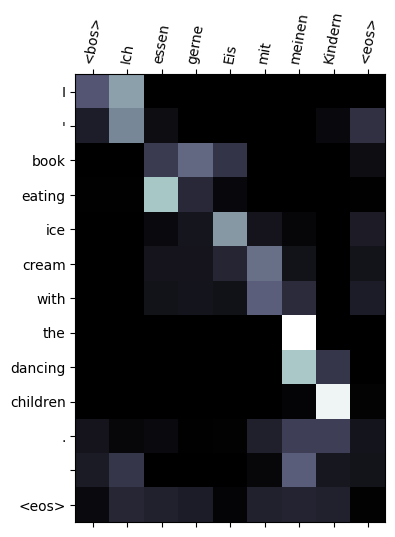

In [30]:
# try out different sentences here!
analyze_sentence("Ich essen gerne Eis mit meinen Kindern")

## Conceptual Questions
- Translate the sentence "*Drei Kinder essen Eis, während ein Elternteil zuschaut*" into English and look at the attention map. In English, this sentence means "Three kids eat ice cream, while a parent watches."
- Translate the sentence "*Ich essen gerne Eis mit meinen Kindern*" into English and look at the attention map. In English, this sentence means "I like to eat ice cream with my children."

1. Compare the quality of the translations of these sentences, using the attention maps as an aid, and try translating other German sentences as well. What is the difference between the attention maps for correct and less correct translations?

More correct translations tend to have more "stark" attention maps. The model is a lot more sure that a certain German word maps to a certain English word, so the attention weight for that pair is high and the surrounding weights are near 0. Less correct translations have "fuzzier" attention maps. There appears to be some noise and uncertainty in the attention weights and many words do not have any significant weight at all. For example, the word "gerne" does not have a corresponding English word/phrase with a high attention weight (the closest is "book").

2. Try looking up the paper for the Multi30k dataset online, and see where our language data came from. Does that provide an explanation for why some sentences have better translations than others? Would this model work very well for translating something like a text conversation?

    The Multi30k dataset is an extension of the Flickr30k dataset. The Flickr30k dataset is a collection of about 30 thousand images sourced from online photo sharing websites. Each image has 5 descriptions (written in English by Mechanical Turk workers). The Multi30k dataset is comprised of translations and independent descriptions. One English description for each image was translated into German and additionally, 5 descriptions were written in German for each image.
   
    This explains why sentences that could reasonably be image descriptions (such as "Three kids eat ice cream, while a parent watches.") have much better translations than other sentences that are less likely to be image descriptions (such as "I like to eat ice cream with my children.").
   
    This model would not work well for translating a text conversation because most of these sentences would be about a person's thoughts or activities (ex. "I'm on my way", "Are you free for lunch?", "Happy birthday!"). These are very unlike image captions/descriptions, and so would not have good results from a model trained on the Multi30k dataset.

In [ ]:
print("Great translation")
analyze_sentence("Drei Kinder essen Eis, während ein Elternteil zuschaut")

print("Poor translation")
analyze_sentence("Ich essen gerne Eis mit meinen Kindern")